# Natural Language Processing

Download the Data Science from Scratch repository into the folder `dsfs`.

In [1]:
import os

if not os.path.isdir('dsfs'):
    !git clone --depth 1 https://github.com/joelgrus/data-science-from-scratch dsfs

Import the needed functions.

In [2]:
import sys
sys.path.append('dsfs') # fix imports

from dsfs.scratch.linear_algebra import dot, Vector, magnitude, subtract, scalar_multiply
from dsfs.scratch.deep_learning import Tensor, Layer, Tensor, random_tensor, zeros_like, tensor_apply, tanh, Sequential, Linear, SoftmaxCrossEntropy, Momentum, GradientDescent, softmax
from dsfs.scratch.gradient_descent import gradient_step

<Figure size 432x288 with 0 Axes>

In [3]:
# from working_with_data.py
# (couldn't import them due to errors)

from typing import List
import tqdm

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")

    return direction(guess)

def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

## Word Clouds

In [4]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

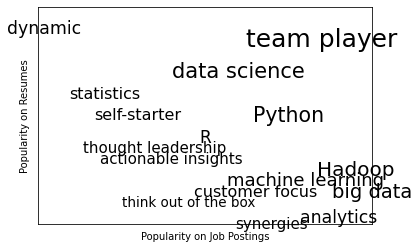

In [5]:
from matplotlib import pyplot as plt

def text_size(total: int) -> float:
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
                ha='center', va='center',
                size=text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

## n-Gram Language Models

In [6]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

In [7]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

# parent div now has the class 'main-post-radar-content'
content = soup.find("div", "main-post-radar-content")

regex = r"[\w']+|[\.]" # matches a word or a period
document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

document[:3]

['Weâ', 've', 'all']

In [8]:
from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

In [9]:
def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

In [10]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

In [11]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

## Grammars

In [12]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

In [13]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

In [14]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

In [15]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

## An Aside: Gibbs Sampling

In [16]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

In [17]:
def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

In [18]:
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [19]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [20]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

## Topic Modeling

In [21]:
def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

In [22]:
from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [23]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [24]:
K = 4

In [25]:
# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

In [26]:
# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

In [27]:
# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

In [28]:
# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

In [29]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

In [30]:
D = len(documents)

In [31]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

In [32]:
def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

In [33]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [34]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 4457.32it/s]


In [35]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [36]:
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

In [37]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

## Word Vectors

In [38]:
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal"

In [39]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50

random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

In [40]:
class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # mapping word -> word_id
        self.i2w: Dict[int, str] = {}  # mapping word_id -> word

        for word in (words or []):     # If words were provided,
            self.add(word)             # add them.

    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # If the word is new to us:
            word_id = len(self.w2i)     # Find the next id.
            self.w2i[word] = word_id    # Add to the word -> word_id map.
            self.i2w[word_id] = word    # Add to the word_id -> word map.

    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """return the word with the given id (or None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

In [41]:
vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3,              "there are 3 words in the vocab"
assert vocab.get_id("b") == 1,       "b should have word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z is not in the vocab"
assert vocab.get_word(2) == "c",     "word_id 2 should be c"
vocab.add("z")
assert vocab.size == 4,              "now there are 4 words in the vocab"
assert vocab.get_id("z") == 3,       "now z should have id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

In [42]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)       # Only need to save w2i

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it.
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

In [43]:
from typing import Iterable

class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # One vector of size embedding_dim for each desired embedding
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)

        # Save last input id
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input id"""
        self.input_id = input_id    # remember for use in backpropagation

        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
        # Zero out the gradient corresponding to the last input.
        # This is way cheaper than creating a new all-zero tensor each time.
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row

        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient

    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

In [44]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructor
        super().__init__(vocab.size, embedding_dim)

        # And hang onto the vocab
        self.vocab = vocab

    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]

        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

In [45]:
import re

# This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text.
vocab = Vocabulary(word
                    for sentence_words in tokenized_sentences
                    for word in sentence_words)

In [46]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):          # For each word
        for j in [i - 2, i - 1, i + 1, i + 2]:   # take the nearby locations
            if 0 <= j < len(sentence):           # that aren't out of bounds
                nearby_word = sentence[j]        # and get those words.

                # Add an input that's the original word_id
                inputs.append(vocab.get_id(word))

                # Add a target that's the one-hot-encoded nearby word
                targets.append(vocab.one_hot_encode(nearby_word))

In [47]:
random.seed(0)
EMBEDDING_DIM = 5  # seems like a good size

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
    # Given a word (as a vector of word_ids), look up its embedding.
    embedding,
    # And use a linear layer to compute scores for "nearby words".
    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

In [48]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)            # Print the loss
    print(embedding.closest("black"))   # and also a few nearest words
    print(embedding.closest("slow"))    # so we can see what's being
    print(embedding.closest("car"))     # learned.

0 2970.156429387063
[(1.0, 'black'), (0.7927247753692507, 'blue'), (0.5911733314896048, 'cat'), (0.5716654981660781, 'the'), (0.3026892975059721, 'car')]
[(1.0, 'slow'), (0.8936272640937163, 'green'), (0.5272141409772461, '.'), (0.356013304388346, 'yellow'), (0.29982973123116025, 'blue')]
[(1.0, 'car'), (0.7030889033452818, 'cat'), (0.519105254858335, 'fast'), (0.4236692673437953, 'very'), (0.3848186865089063, 'quite')]
1 2865.855510833289
[(1.0, 'black'), (0.8076054877794636, 'blue'), (0.6112459000264461, 'cat'), (0.5676562111596322, 'the'), (0.3273307461476133, 'car')]
[(1.0, 'slow'), (0.8795208130766505, 'green'), (0.5675261127213351, '.'), (0.3624106663078739, 'yellow'), (0.3593451263736934, 'boat')]
[(1.0, 'car'), (0.7121322616680856, 'cat'), (0.49717481866583696, 'fast'), (0.4099921723101964, 'very'), (0.3655326707405854, 'quite')]
2 2815.035526656466
[(1.0, 'black'), (0.8240340241906855, 'blue'), (0.6310891601317347, 'cat'), (0.5448895203899405, 'the'), (0.3541498544488745, 'car

In [49]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
            for w1 in vocab.w2i
            for w2 in vocab.w2i
            if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

[(0.9948304450324577, 'bed', 'cat'), (0.9920899253848237, 'seems', 'was'), (0.9883988811665564, 'bed', 'boat'), (0.9821293900663808, 'black', 'blue'), (0.9709525703302307, 'green', 'red')]


dv: 43.206: 100%|██████████| 100/100 [00:00<00:00, 2913.42it/s]


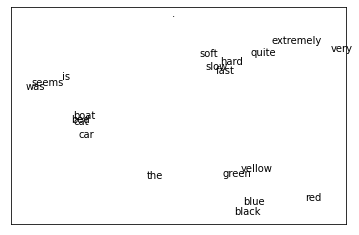

In [50]:
# Extract the first two principal components and transform the word vectors
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)

# Scatter the points (and make them white so they're "invisible")
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')

# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])

# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

## Recurrent Neural Networks

In [51]:
class SimpleRnn(Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.w = random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = random_tensor(hidden_dim)

        self.reset_hidden_state()

    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]

    def forward(self, input: Tensor) -> Tensor:
        self.input = input              # Save both input and previous
        self.prev_hidden = self.hidden  # hidden state to use in backprop.

        a = [(dot(self.w[h], input) +           # weights @ input
              dot(self.u[h], self.hidden) +     # weights @ hidden
              self.b[h])                        # bias
             for h in range(self.hidden_dim)]

        self.hidden = tensor_apply(tanh, a)  # Apply tanh activation
        return self.hidden                   # and return the result.

    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b has the same gradient as a
        self.b_grad = a_grad

        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]

## Example: Using a Character-Level RNN

In [52]:
from bs4 import BeautifulSoup
import requests

url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url).text, 'html5lib')

# Currently they are inside <tr> tags (and now they have 270+ listed)
companies = list({b.text for b in soup("tr")[:101]})

assert len(companies) == 101

companies[:3]

['People.aipeople.ai#83Harnesses business activity to unlock growth.—S16—Redwood City, CAApply',
 'Newfrontnewfront.com#68Modern insurance brokerage.—W18—San Francisco, CAApply',
 'Fivetranfivetran.com#19The global leader in modern data integration —W13Oakland, CAApply']

In [53]:
vocab = Vocabulary([c for company in companies for c in company])

In [54]:
START = "^"
STOP = "$"

# We need to add them to the vocabulary too.
vocab.add(START)
vocab.add(STOP)

In [55]:
HIDDEN_DIM = 32  # You should experiment with different sizes!

rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)

model = Sequential([
    rnn1,
    rnn2,
    linear
])

In [56]:
def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # Reset both hidden states.
    rnn2.reset_hidden_state()
    output = [seed]            # Start the output with the specified seed.

    # Keep going until we produce the STOP character or reach the max length
    while output[-1] != STOP and len(output) < max_len:
        # Use the last character as the input
        input = vocab.one_hot_encode(output[-1])

        # Generate scores using the model
        predicted = model.forward(input)

        # Convert them to probabilities and draw a random char_id
        probabilities = softmax(predicted)
        next_char_id = sample_from(probabilities)

        # Add the corresponding char to our output
        output.append(vocab.get_word(next_char_id))

    # Get rid of START and END characters and return the word.
    return ''.join(output[1:-1])

In [57]:
loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.9)

EPOCHS = 10 # 300

for epoch in range(EPOCHS):
    random.shuffle(companies)  # Train in a different order each epoch.
    epoch_loss = 0             # Track the loss.
    for company in tqdm.tqdm(companies):
        rnn1.reset_hidden_state()  # Reset both hidden states.
        rnn2.reset_hidden_state()
        company = START + company + STOP   # Add START and STOP characters.

        # The rest is just our usual training loop, except that the inputs
        # and target are the one-hot-encoded previous and next characters.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)

    # Each epoch print the loss and also generate a name
    print(epoch, epoch_loss, generate())

    # Turn down the learning rate for the last 100 epochs.
    # There's no principled reason for this, but it seems to work.
    if epoch == 200:
        optimizer.lr *= 0.1

100%|██████████| 101/101 [00:33<00:00,  2.98it/s]


0 35216.75176330703 zHicaau.ie ,ry po uty3oCodnap.aQeonc——oyflttc.si


100%|██████████| 101/101 [00:33<00:00,  3.02it/s]


1 34766.166414594096  s 1urtmmco  R o1n 3res ,#lYAaBpo6eeIeya soobl l


100%|██████████| 101/101 [00:33<00:00,  3.02it/s]


2 33976.63369182748 Zep fntla0creoci—taayinsb


100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


3 31740.565235488182 W—)—7.Ae-lin⁣orga  hloecoopal6Fraisb v dly


100%|██████████| 101/101 [00:34<00:00,  2.94it/s]


4 29933.949224497446 9ailpen 6ianpos —W6Plemanmotcobfi #2AA ancu,ciet


100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


5 27930.74862827235 Priom an—E15—Ran#Frceul goln-CNO—N19ep .ongaresf


100%|██████████| 101/101 [00:33<00:00,  2.98it/s]


6 25769.091027364757 2anmFulityr Ecegilesio pl eblycamerosetetiueertd


100%|██████████| 101/101 [00:33<00:00,  2.97it/s]


7 24437.044225976122 Sen boblybetinciscuncigteri.frate ele sncon pare


100%|██████████| 101/101 [00:33<00:00,  2.98it/s]


8 23532.647881902023 Fo tasee Cpply


100%|██████████| 101/101 [00:33<00:00,  2.99it/s]

9 22868.08496460992 Tanlins co wovtans—W1MMe mory—WD1De mes s.—7—Sen
